In [25]:
from sirf.STIR import (ImageData, AcquisitionData,
                       SPECTUBMatrix, AcquisitionModelUsingMatrix,
                       MessageRedirector,)
from simind import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import numpy as np
from numba import jit, prange

In [26]:
msg = MessageRedirector()
AcquisitionData.set_storage_scheme('memory')

In [27]:
# SIMIND parameters
total_activity = 258.423 # MBq
time_per_projection = 43 # seconds
photon_multiplier = 0.001 # EXPLAIN (tiny)
photopeak_energy = 208 # keV
window_lower = 187.56 # keV
window_upper = 229.24 # keV
source_type = "lu177" 
collimator = 'ma-megp'
kev_per_channel = 1
num_energy_spectra_channels = 300 # EXPLAIN better

In [28]:
image = ImageData(os.path.join(os.getcwd(), "data/Lu177/osem_reconstruction_postfilter_555.hv"))
mu_map = ImageData(os.path.join(os.getcwd(), "data/Lu177/registered_CTAC.hv"))
measured_data = AcquisitionData(os.path.join(os.getcwd(), "data/Lu177/SPECTCT_NEMA_128_EM001_DS_en_1_Lu177_EM.hdr"))

In [29]:
mu_map_stir = mu_map.clone()
mu_map_stir.fill(np.flip(mu_map.as_array(), axis=2))

In [30]:
create_window_file(window_lower, window_upper, scatter_orders=0, output_filename= "input.win" )

In [31]:
simulator = SimindSimulator(input_filepath=".", output_filepath=".",)
attributes = {"SourceMap": image,
              "MuMap": mu_map,
              "keVPerChannel": kev_per_channel, 
              'NumberOfEnergySpectraChannels': num_energy_spectra_channels,
              "PhotopeakEnergy": photopeak_energy,
              "SourceActivity": total_activity,
              "PhotonMultiplier": photon_multiplier,
              "ImageDurationPerProjection": time_per_projection,
              "SourceType": source_type.lower(),
              "Collimator": collimator,}
simulator.set_template_sinogram(measured_data)
simulator.set_attributes(attributes)

In [32]:
simulator.run_simulation()

Clearing all files in . that could cause trouble...
This includes:
 - .h00, .hs, .a00, .hct, .ict, .bis, .res
if this is not what you want, please cancel this process now.
5


4
3
2
1
removed output_air_w1.a00
removed tmp.hs
removed output_sca_w2.a00
removed output_tot_w1.a00
removed output_sca_w1.a00
All required attributes are set and ready for simulation.
All relevant files exist in ..
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
sy

In [33]:
simind_total = simulator.get_output_total()
simind_scatter = simulator.get_output_scatter()
simind_true = simind_total - simind_scatter

Output in ./output_air_w1.hs

Output in ./output_tot_w1.hs

Output in ./output_sca_w1.hs

Output in ./output_sca_w2.hs






In [34]:
acq_matrix = SPECTUBMatrix()
acq_matrix.set_attenuation_image(mu_map_stir)
acq_matrix.set_keep_all_views_in_cache(True)
acq_matrix.set_resolution_model(1.81534, 0.02148, False)
acq_model = AcquisitionModelUsingMatrix(acq_matrix)
acq_model.set_up(measured_data, image)

In [35]:
#stir_forward_projection = acq_model.forward(image)
stir_forward_projection = measured_data.clone()

In [36]:
scaling_factor = measured_data.sum()/simind_total.sum()

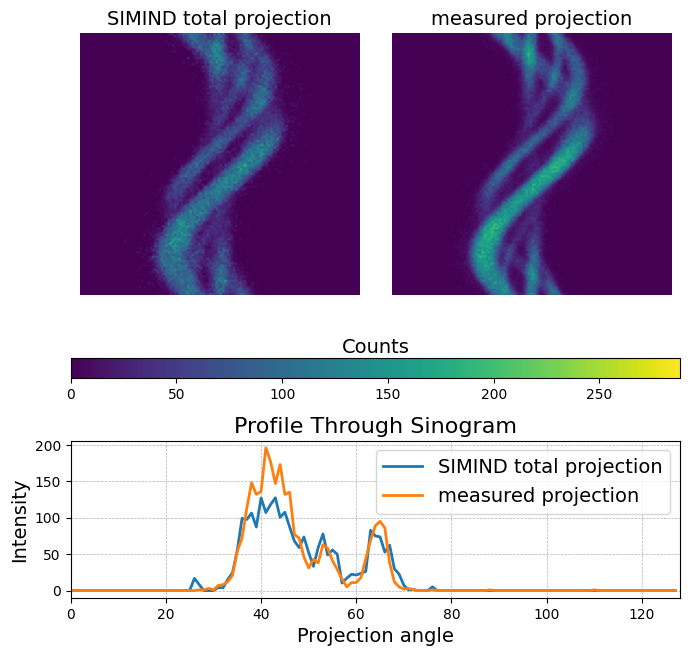

In [37]:
# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'
axial_slice = 65

# Set the maximum intensity for color normalization
vmax = max(measured_data.max(), simind_total.max(), stir_forward_projection.max())

data_list = [
    (simind_total.as_array()[0, axial_slice]*scaling_factor, "SIMIND total projection"),
    (measured_data.as_array()[0, axial_slice], "measured projection"),
]

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(7,6.5))
gs = GridSpec(3, 2, height_ratios=[2, 0.15, 1.2])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(2)]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data, vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[100], label=title, linewidth=line_width)

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper right', fontsize=font_size)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()

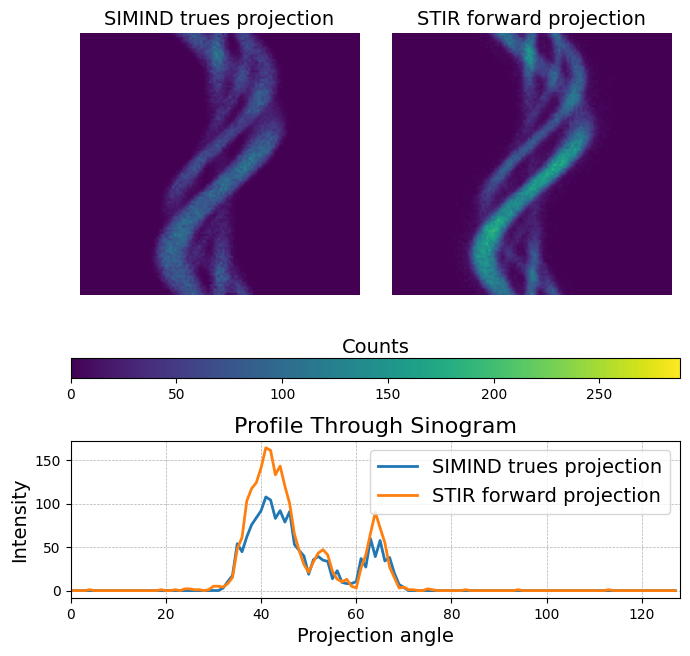

In [38]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Your other code for setting up data would be here

# Assuming 'measured_data', 'simind_total', 'stir_forward_projection', etc. are defined earlier in your script

# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'
axial_slice = 67

# Set the maximum intensity for color normalization
vmax = max(measured_data.max(), simind_total.max(), stir_forward_projection.max())

data_list = [
    (simind_true.as_array()[0, axial_slice]*scaling_factor, "SIMIND trues projection"),
    (stir_forward_projection.as_array()[0, axial_slice], "STIR forward projection")
]

# Create a figure and a GridSpec with 3 rows
fig = plt.figure(figsize=(7,6.5))
gs = GridSpec(3, 2, height_ratios=[2, 0.15, 1.2])  # Adjusted GridSpec for clarity

# Create image subplots in the first row
ax_images = [fig.add_subplot(gs[0, i]) for i in range(2)]

for i, (data, title) in enumerate(data_list):
    im = ax_images[i].imshow(data, vmin=0, vmax=vmax, cmap=colormap)
    ax_images[i].set_title(f"{title}", fontsize=font_size)
    ax_images[i].axis('off')

# Place a colorbar in a new row, just for the colorbar
cbar_ax = fig.add_subplot(gs[1, :])  # Spanning across the bottom of the image plots
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', pad=0.02)  # Reduced padding
cbar_ax.set_xlabel('Counts', fontsize=font_size)
cbar_ax.xaxis.set_label_position('top')

# Set consistent font size and line width for the line plot
line_width = 2

# Create line plot in the third row
ax_line = fig.add_subplot(gs[2, :])  # Spanning across both columns in the third row

# Plotting
for i, (data, title) in enumerate(data_list):
    ax_line.plot(data[100], label=title, linewidth=line_width)

# Enhance the appearance of the line plot
ax_line.set_xlabel('Projection angle', fontsize=font_size)
ax_line.set_ylabel('Intensity', fontsize=font_size)
ax_line.set_title(f'Profile Through Sinogram', fontsize=font_size + 2)
ax_line.grid(True, which='both', linestyle='--', linewidth=0.5)
ax_line.legend(loc='upper right', fontsize=font_size)
# et minimum and maximum values for x-axis
ax_line.set_xlim(0, 128)

# Adjust spacing and layout
plt.tight_layout()
plt.show()


In [128]:
from numba import prange, jit
import numpy as np

from numba import prange, jit
import numpy as np

@jit(forceobj=True, parallel=True)
def calculate_patch_sums(array, patch_size, fraction_at_end=True):
    sums = []

    num_patches_i = (array.shape[0] + patch_size[0] - 1) // patch_size[0]
    num_patches_j = (array.shape[1] + patch_size[1] - 1) // patch_size[1]
    num_patches_k = (array.shape[2] + patch_size[2] - 1) // patch_size[2]

    small_patch_size_i = array.shape[0] % patch_size[0] or patch_size[0]
    small_patch_size_j = array.shape[1] % patch_size[1] or patch_size[1]
    small_patch_size_k = array.shape[2] % patch_size[2] or patch_size[2]

    for i in prange(num_patches_i):
        for j in prange(num_patches_j):
            for k in prange(num_patches_k):
                if fraction_at_end:
                    # Regular patches
                    patch_start_i = i * patch_size[0]
                    patch_start_j = j * patch_size[1]
                    patch_start_k = k * patch_size[2]

                    patch_end_i = patch_start_i + patch_size[0]
                    patch_end_j = patch_start_j + patch_size[1]
                    patch_end_k = patch_start_k + patch_size[2]
                else:
                    # Fractional patch at start
                    if i == 0:
                        patch_start_i = 0
                        patch_end_i = small_patch_size_i
                    else:
                        patch_start_i = small_patch_size_i + (i - 1) * patch_size[0]
                        patch_end_i = patch_start_i + patch_size[0]

                    if j == 0:
                        patch_start_j = 0
                        patch_end_j = small_patch_size_j
                    else:
                        patch_start_j = small_patch_size_j + (j - 1) * patch_size[1]
                        patch_end_j = patch_start_j + patch_size[1]

                    if k == 0:
                        patch_start_k = 0
                        patch_end_k = small_patch_size_k
                    else:
                        patch_start_k = small_patch_size_k + (k - 1) * patch_size[2]
                        patch_end_k = patch_start_k + patch_size[2]

                # Adjust for the last patch in each dimension
                patch_end_i = min(patch_end_i, array.shape[0])
                patch_end_j = min(patch_end_j, array.shape[1])
                patch_end_k = min(patch_end_k, array.shape[2])

                patch = array[patch_start_i:patch_end_i, patch_start_j:patch_end_j, patch_start_k:patch_end_k]
                sums.append(np.sum(patch))

    return sums


@jit(forceobj=True, parallel=True)
def normalise_patches(reference, floating, patch_size, fraction_at_end=True):
    ref_sums = calculate_patch_sums(reference, patch_size, fraction_at_end)
    float_sums = calculate_patch_sums(floating, patch_size, fraction_at_end)

    num_patches_i = (reference.shape[0] + patch_size[0] - 1) // patch_size[0]
    num_patches_j = (reference.shape[1] + patch_size[1] - 1) // patch_size[1]
    num_patches_k = (reference.shape[2] + patch_size[2] - 1) // patch_size[2]

    small_patch_size_i = reference.shape[0] % patch_size[0] or patch_size[0]
    small_patch_size_j = reference.shape[1] % patch_size[1] or patch_size[1]
    small_patch_size_k = reference.shape[2] % patch_size[2] or patch_size[2]

    for i in prange(num_patches_i):
        for j in prange(num_patches_j):
            for k in prange(num_patches_k):
                if fraction_at_end:
                    # Regular patches
                    patch_start_i = i * patch_size[0]
                    patch_start_j = j * patch_size[1]
                    patch_start_k = k * patch_size[2]

                    patch_end_i = patch_start_i + patch_size[0]
                    patch_end_j = patch_start_j + patch_size[1]
                    patch_end_k = patch_start_k + patch_size[2]
                else:
                    # Fractional patch at start
                    if i == 0:
                        patch_start_i = 0
                        patch_end_i = small_patch_size_i
                    else:
                        patch_start_i = small_patch_size_i + (i - 1) * patch_size[0]
                        patch_end_i = patch_start_i + patch_size[0]

                    if j == 0:
                        patch_start_j = 0
                        patch_end_j = small_patch_size_j
                    else:
                        patch_start_j = small_patch_size_j + (j - 1) * patch_size[1]
                        patch_end_j = patch_start_j + patch_size[1]

                    if k == 0:
                        patch_start_k = 0
                        patch_end_k = small_patch_size_k
                    else:
                        patch_start_k = small_patch_size_k + (k - 1) * patch_size[2]
                        patch_end_k = patch_start_k + patch_size[2]

                # Adjust for the last patch in each dimension
                patch_end_i = min(patch_end_i, floating.shape[0])
                patch_end_j = min(patch_end_j, floating.shape[1])
                patch_end_k = min(patch_end_k, floating.shape[2])

                patch = floating[patch_start_i:patch_end_i, patch_start_j:patch_end_j, patch_start_k:patch_end_k]
                idx = i * ((floating.shape[1] + patch_size[1] - 1) // patch_size[1]) * ((floating.shape[2] + patch_size[2] - 1) // patch_size[2]) + j * ((floating.shape[2] + patch_size[2] - 1) // patch_size[2]) + k
                if float_sums[idx] != 0:
                    ratio = ref_sums[idx] / float_sums[idx]
                    patch *= ratio

    return floating

@jit(forceobj=True, parallel=True)
def normalise_patches_and_apply(reference, floating, application, patch_size, fraction_at_end=True):
    ref_sums = calculate_patch_sums(reference, patch_size, fraction_at_end)
    float_sums = calculate_patch_sums(floating, patch_size, fraction_at_end)

    num_patches_i = (reference.shape[0] + patch_size[0] - 1) // patch_size[0]
    num_patches_j = (reference.shape[1] + patch_size[1] - 1) // patch_size[1]
    num_patches_k = (reference.shape[2] + patch_size[2] - 1) // patch_size[2]

    small_patch_size_i = reference.shape[0] % patch_size[0] or patch_size[0]
    small_patch_size_j = reference.shape[1] % patch_size[1] or patch_size[1]
    small_patch_size_k = reference.shape[2] % patch_size[2] or patch_size[2]

    for i in prange(num_patches_i):
        for j in prange(num_patches_j):
            for k in prange(num_patches_k):
                if fraction_at_end:
                    # Regular patches
                    patch_start_i = i * patch_size[0]
                    patch_start_j = j * patch_size[1]
                    patch_start_k = k * patch_size[2]

                    patch_end_i = patch_start_i + patch_size[0]
                    patch_end_j = patch_start_j + patch_size[1]
                    patch_end_k = patch_start_k + patch_size[2]
                else:
                    # Fractional patch at start
                    if i == 0:
                        patch_start_i = 0
                        patch_end_i = small_patch_size_i
                    else:
                        patch_start_i = small_patch_size_i + (i - 1) * patch_size[0]
                        patch_end_i = patch_start_i + patch_size[0]

                    if j == 0:
                        patch_start_j = 0
                        patch_end_j = small_patch_size_j
                    else:
                        patch_start_j = small_patch_size_j + (j - 1) * patch_size[1]
                        patch_end_j = patch_start_j + patch_size[1]

                    if k == 0:
                        patch_start_k = 0
                        patch_end_k = small_patch_size_k
                    else:
                        patch_start_k = small_patch_size_k + (k - 1) * patch_size[2]
                        patch_end_k = patch_start_k + patch_size[2]

                # Adjust for the last patch in each dimension
                patch_end_i = min(patch_end_i, floating.shape[0])
                patch_end_j = min(patch_end_j, floating.shape[1])
                patch_end_k = min(patch_end_k, floating.shape[2])

                patch = application[patch_start_i:patch_end_i, patch_start_j:patch_end_j, patch_start_k:patch_end_k]
                idx = i * ((floating.shape[1] + patch_size[1] - 1) // patch_size[1]) * ((floating.shape[2] + patch_size[2] - 1) // patch_size[2]) + j * ((floating.shape[2] + patch_size[2] - 1) // patch_size[2]) + k
                if float_sums[idx] != 0:
                    ratio = ref_sums[idx] / float_sums[idx]
                    patch *= ratio

    return floating


In [129]:
tst_meas = AcquisitionData(os.path.join(os.getcwd(), "data/Y90/peak_1_projdata__f1g1d0b0.hs"))
tst_simi = AcquisitionData(os.path.join(os.getcwd(), "data/Y90/simind_total_osem_555.hs"))

In [137]:
tst_meas.shape

(1, 128, 120, 128)

In [149]:
patch_normalised_end_353 = normalise_patches(tst_meas.as_array()[0], tst_simi.as_array()[0], (3, 5, 3), True)
patch_normalised_start_353 = normalise_patches(tst_meas.as_array()[0], tst_simi.as_array()[0], (3, 5, 3), False)
patch_normalised_end_696 = normalise_patches(tst_meas.as_array()[0], tst_simi.as_array()[0], (6, 9, 6), True)
patch_normalised_start_696 = normalise_patches(tst_meas.as_array()[0], tst_simi.as_array()[0], (6, 9, 6), False)
patch_normalised_end_151815 = normalise_patches(tst_meas.as_array()[0], tst_simi.as_array()[0], (15, 18, 15), True)
patch_normalised_start_151815 = normalise_patches(tst_meas.as_array()[0], tst_simi.as_array()[0], (15, 18, 15), False)
patch_normalised = (patch_normalised_end_353 + patch_normalised_start_353 + patch_normalised_end_696 + patch_normalised_start_696 + patch_normalised_end_151815 + patch_normalised_start_151815)/6

In [153]:
norm_factor_sinogram = (tst_meas.as_array()[0]/patch_normalised)

/tmp/ipykernel_9785/2393621394.py:1: RuntimeWarning: divide by zero encountered in divide
  norm_factor_sinogram = (tst_meas.as_array()[0]/patch_normalised)
/tmp/ipykernel_9785/2393621394.py:1: RuntimeWarning: invalid value encountered in divide
  norm_factor_sinogram = (tst_meas.as_array()[0]/patch_normalised)


In [152]:
print(f"normalised counts: {patch_normalised.sum()}")
print(f"measured counts: {tst_meas.sum()}")

normalised counts: 4139659.25
measured counts: 4140417.75


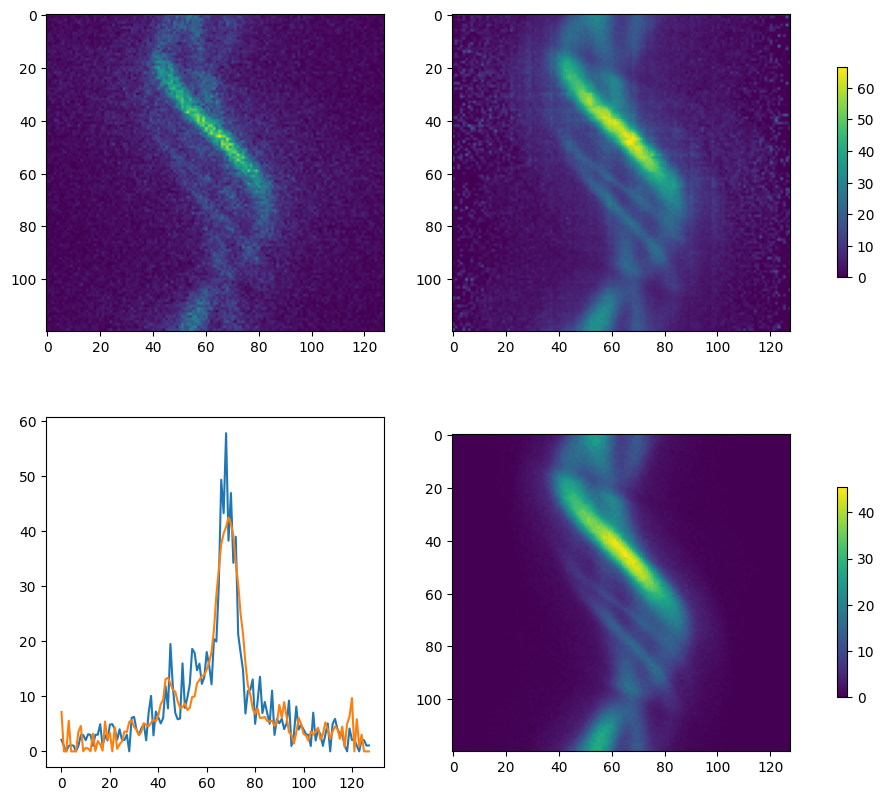

In [150]:
fig, ax  = plt.subplots(2, 2, figsize=(12, 10))
im0 = ax[0,0].imshow(tst_meas.as_array()[0, 55], cmap='viridis')
im1 = ax[0,1].imshow(patch_normalised[55], cmap='viridis')
ax[1,0].plot(tst_meas.as_array()[0, 55, 50], label='measured')
ax[1,0].plot(patch_normalised[55, 50], label='patch normalised')
ax[1,1].imshow(tst_simi.as_array()[0, 55], label='simind')

#colorbar
fig.colorbar(im0, ax=ax[0], shrink=0.6)
fig.colorbar(im1, ax=ax[1], shrink=0.6)

In [55]:
print(measured_data.sum())
print(simind_total.sum())
print(np.sum(patch_normalised))

2744865.0
3663171.2
2704477.5
